In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
# from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *
from sphMath.reference.sod import plotSod

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
dtype = torch.float64

nx = 200
dim = 1
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4, 1)
CFL = 0.3

gamma = 5/3

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.MonaghanScheme

domain = buildDomainDescription(l = 2, dim = 1, periodic = True, device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)
# particleSystem = generateSod1D(nx, ratio, initialStateLeft, initialStateRight, gamma, solverConfig['kernel'], targetNeighbors, dtype, device, smoothIC, SimulationSystem)

# dt = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)
# dt = computeDT(particleSystem.systemState, CFL, solverConfig)
# timesteps = int(timeLimit / dt)

In [3]:

r_inner = 0.9
r_outer = 1.0
dx = (r_outer - r_inner) / (nx - 1)
print(dx)

particles_l = sampleRegularParticles(nx, domain, targetNeighbors, jitter = 0.0)

0.0005025125628140703
True: dxs: [tensor(0.0100, dtype=torch.float64)], ns: [tensor(200, dtype=torch.int32)], nx: 200


In [11]:
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.compressible import CompressibleState
from sphMath.modules.density import computeDensity
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr

Pinitial = torch.zeros_like(particles_l.densities)
r = torch.linalg.norm(particles_l.positions, dim = -1)
rhoInitial = torch.ones_like(particles_l.densities)
v_initial = - torch.nn.functional.normalize(particles_l.positions, dim = -1)
# particles_l = particles_l._replace(masses = particles_l.masses * rhoInitial, densities = rhoInitial)

A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)

internalEnergy = u_ 
kineticEnergy = torch.linalg.norm(v_initial, dim = -1) **2/ 2
totalEnergy = (internalEnergy + kineticEnergy) * particles_l.masses

simulationState = CompressibleState(
    positions = particles_l.positions,
    supports = particles_l.supports,
    masses = particles_l.masses,
    densities = particles_l.densities,        
    velocities = v_initial,

    kinds = torch.zeros_like(particles_l.positions[:,0], dtype = torch.int32),
    materials = torch.zeros_like(particles_l.positions[:,0], dtype = torch.int32),
    UIDs = torch.arange(particles_l.positions.shape[0], device = device, dtype = torch.int32),
    
    internalEnergies = u_,
    totalEnergies = totalEnergy,
    entropies = A_,
    pressures = P_,
    soundspeeds = c_s,

    alphas = torch.ones_like(particles_l.densities),
    alpha0s = torch.ones_like(particles_l.densities)
)

from sphMath.neighborhood import evaluateNeighborhood, filterNeighborhoodByKind, SupportScheme
neighborhood, neighbors = evaluateNeighborhood(simulationState, domain, kernel, verletScale = 1.0, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
numNeighbors = coo_to_csr(filterNeighborhoodByKind(simulationState, neighbors.neighbors, which = 'noghost')).rowEntries
densities = computeDensity(simulationState, kernel, neighbors.get('noghost'), SupportScheme.Gather, solverConfig)
A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)
simulationState.internalEnergies = u_

particleSystem = SimulationSystem(
        systemState = simulationState,
        domain = domain,
        neighborhoodInfo = neighborhood,
        t = 0
    )
# particles.densities, particles.pressures, particles.internalEnergies, particles.entropies, particles.soundspeeds = config['imposeState'](particles, domain, wrappedKernel, actualNeighbors, config, SPHSystem.t)

c_s[:] = 1
particleSystem.systemState.soundspeeds[:] = 1

timeLimit = 1.0
dt = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)
dt = torch.tensor(1e-4, dtype = dtype, device = device)
timesteps = int(timeLimit / dt)
simulationState = copy.deepcopy(particleSystem)

print(timesteps, dt)

print(c_s, particles_l.supports.min(), particles_l.supports.max())

10000 tensor(0.0001, dtype=torch.float64)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], dtype=torch.float64) tensor(0.0400, dtype=torch.float64) tens

In [12]:
rho_0 = 1
v_s = 1/3
rho_s = rho_0 * ((gamma+1) / (gamma-1))**dim
P_s = v_s * rho_s

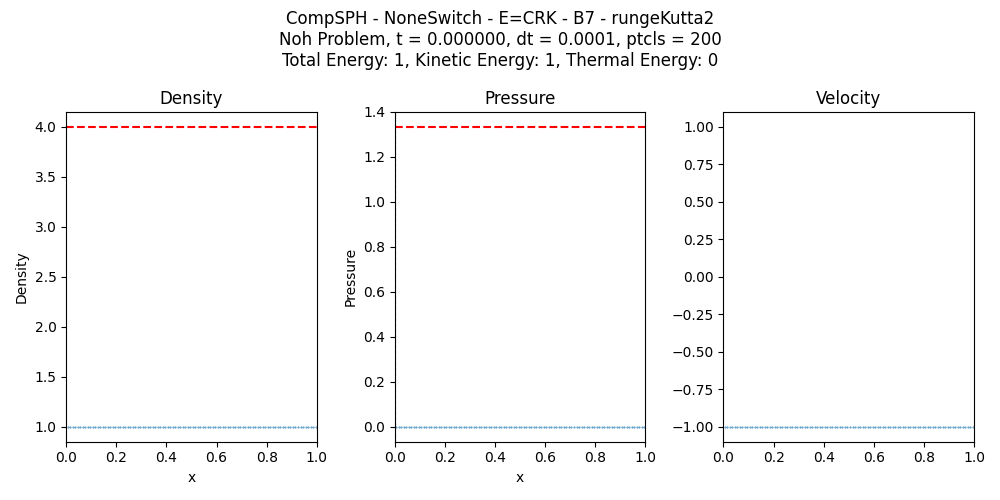

In [13]:
fig, axis = plt.subplots(1, 3, figsize = (10, 5), squeeze=False)

axis[0,0].scatter(simulationState.systemState.positions, simulationState.systemState.densities, s = 32/nx)
axis[0,0].set_title('Density')
axis[0,0].set_xlabel('x')
axis[0,0].set_ylabel('Density')
axis[0,0].axhline(rho_s, color = 'r', linestyle = '--')

axis[0,1].scatter(simulationState.systemState.positions, simulationState.systemState.pressures, s = 32/nx)
axis[0,1].set_title('Pressure')
axis[0,1].set_xlabel('x')
axis[0,1].set_ylabel('Pressure')
axis[0,1].axhline(P_s, color = 'r', linestyle = '--')
axis[0,1].axvline(v_s * simulationState.t, color = 'black', linestyle = ':', alpha = 0.5)
axis[0,1].axvline(-v_s * simulationState.t, color = 'black', linestyle = ':', alpha = 0.5)

axis[0,2].scatter(simulationState.systemState.positions, simulationState.systemState.velocities[:,0], s = 32/nx)
axis[0,2].set_title('Velocity')


kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
totalEnergy = kineticEnergy + thermalEnergy
fig.suptitle(f'{solverConfig["schemeName"]}\nNoh Problem, t = {simulationState.t:2f}, dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')
# fig.canvas.draw()
for ax in axis.flatten():
    ax.set_xlim(0, 1)
fig.tight_layout()


In [14]:

import math
fps = 50
exportInterval = 1 / fps
exportSteps = int(math.ceil(exportInterval / dt))
newDt = exportInterval / exportSteps
plotInterval = int(math.floor(exportInterval / newDt))
plotInterval = min(max(plotInterval,1), 40)
print(f'Current dt: {dt}')
print(f'Plot Interval: {plotInterval}')
print(f'export Steps: {exportSteps}')
print(f'New dt: {newDt}')

imagePrefix = './images/noh_1D/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)

Current dt: 0.0001
Plot Interval: 40
export Steps: 200
New dt: 0.0001


In [15]:

states = []
priorStep = None
# plotInterval = 50


for i in (tq:=tqdm(range(timesteps))):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)

    simulationState.priorStep = [updates[-1], currentState[-1]]
    
    states.append(copy.deepcopy(simulationState.to(device = 'cpu')))

    kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
    thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
    totalEnergy = kineticEnergy + thermalEnergy

    tq.set_postfix({
        'Kinetic Energy': kineticEnergy.item(),
        'Thermal Energy': thermalEnergy.item(),
        'Total Energy': totalEnergy.item(),
        'Time': simulationState.t.item()
    })
    if (i % plotInterval == 0 and i > 0) or i == timesteps - 1:
        axis[0,0].cla()
        axis[0,1].cla()
        axis[0,2].cla()


        axis[0,0].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.densities.cpu().numpy(), s = 1)
        axis[0,1].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.pressures.cpu().numpy(), s = 1)
        axis[0,2].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.velocities.cpu().numpy(), s = 1)

        for ax in axis.flatten():
            ax.axvline(v_s * simulationState.t.cpu().item(), color = 'black', linestyle = ':', alpha = 0.5)
            ax.axvline(-v_s * simulationState.t.cpu().item(), color = 'black', linestyle = ':', alpha = 0.5)
        axis[0,0].axhline(rho_s, color = 'r', linestyle = '--')
        axis[0,1].axhline(P_s, color = 'r', linestyle = '--')

        axis[0,0].set_title('Density')
        axis[0,1].set_title('Pressure')
        axis[0,2].set_title('Velocity')
        for ax in axis.flatten():
            ax.set_xlim(0, 1)

        fig.suptitle(f'{solverConfig["schemeName"]}\nNoh Problem, t = {simulationState.t:2f}, dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
from sphMath.util import postProcess

postProcess(
    imagePrefix = imagePrefix,
    fps = 50,
    exportName = 'noh_1D',
    targetLongEdge = 600
)
# def postProcess(imagePrefix, fps, exportName, targetLongEdge = 600):

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Copying video to videos folder
Done!
